这一节，我们用训练好的模型去提取影像中的建筑，并保存到geojson中。

In [8]:
%env AWS_NO_SIGN_REQUEST=YES

env: AWS_NO_SIGN_REQUEST=YES


`raster-vision`提供了一个训练好的模型，我们可以拿它来做预测。如果我们不需要对模型进行在训练，那我们就不需要模型的定义，直接导入就行。

In [7]:
bundle_uri = 's3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip'

In [3]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(bundle_uri, training=False)

2025-03-28 09:21:11:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle s3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip.
2025-03-28 09:21:11:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip.
2025-03-28 09:21:11:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpyo74qufi/model-bundle
2025-03-28 09:21:14:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpyo74qufi/model-bundle/model.pth


准备下我们的数据， label_uri是真值，image_uri是我们要预测的影像

In [4]:
scene_id = 5631
image_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img{scene_id}.tif'
label_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{scene_id}.geojson'

In [17]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['building', 'background'],
    colors=['orange', 'black'],
    null_class='background',
)
class_config.ensure_null_class()

在影像训练的时候，我们通常会做一些`Transformer`，尤其是`StatsTransformer`，它是为了能够处理离群值（类似于滤波）。它的工作原理是使用通道均值和标准差将值转换为`z分数`，缩放到`0-255`并转换为`uint8`。所以在影像推理的时候，如果有这个操作，那我们同样也要加上。

In [19]:
from rastervision.core.data import StatsTransformer

stats_uri = 's3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/analyze/stats/train_scenes/stats.json'
stats_tf = StatsTransformer.from_stats_json(stats_uri)
stats_tf

StatsTransformer(means=array([424.87790094, 592.92457995, 447.27932498]), stds=array([220.60852518, 242.79340345, 148.50591309]), max_stds=3.0)

然后我们就去创建一个数据集，这里我们用`SemanticSegmentationSlidingWindowGeoDataset`，去对整幅影像进行识别，最终`raster-vision`会帮我们把结果合并在一起

In [32]:
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset

ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    image_raster_source_kw=dict(raster_transformers=[stats_tf]),
    size=325,
    stride=325,
    out_size=325,
)

2025-03-28 09:59:37:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img5631.tif.


预测的话，首先是直接对影像进行推理，然后因为我们是语义分隔`SemanticSegmentation`，所以我们需要导出为`SemanticSegmentationLabels`

In [29]:
from rastervision.core.data import SemanticSegmentationLabels

predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(325, 325)),
    progress_bar=True)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config))

Predicting:   0%|          | 0/36 [00:00<?, ?it/s]

In [34]:
scores = pred_labels.get_score_arr(pred_labels.extent)
len(scores)

2

`scores`里保存的就是各类`class`的识别结果

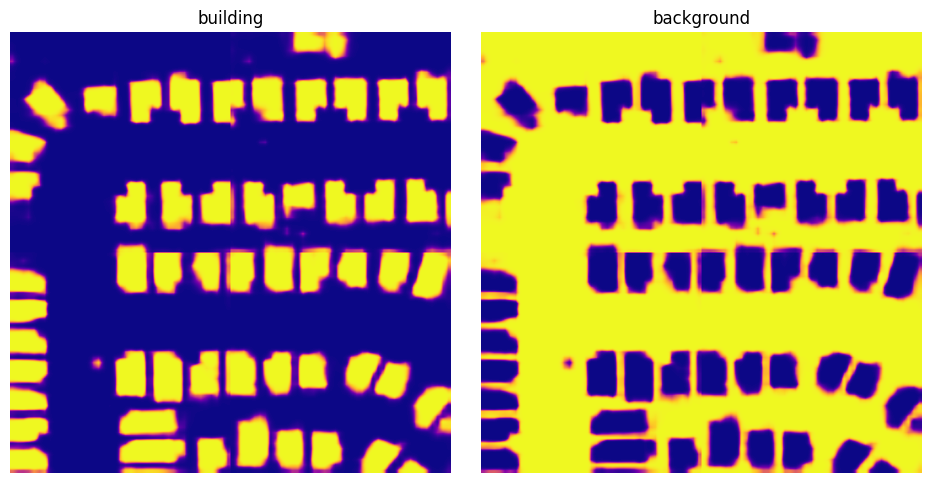

In [30]:
from matplotlib import pyplot as plt

scores_building = scores[0]
scores_background = scores[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_building, cmap='plasma')
ax1.axis('off')
ax1.set_title('building')
ax2.imshow(scores_background, cmap='plasma')
ax2.axis('off')
ax2.set_title('background')
plt.show()

In [35]:
pred_labels.save(
    uri=f'data/spacenet-vegas-buildings-ss/predict/{scene_id}',
    crs_transformer=ds.scene.raster_source.crs_transformer,
    class_config=class_config)

Saving pixel labels:   0%|          | 0/2 [00:00<?, ?it/s]

Saving pixel scores:   0%|          | 0/2 [00:00<?, ?it/s]